# Analyzing S & P robot data

## Import libraries

In [1]:
import os, os.path

In [2]:
from skimage import io,util

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

## Convert pictures (crop, levels of gray,...)

In [50]:
def get_modified_image(image, outp, pic_fname, xoff=520, yoff=315):
    # xoff are yoff the number of pixels that will be cropped from the picture
    
    #Output folder is created only if it doesn't already exist
    from pathlib import Path
    Path(outp).mkdir(parents=True, exist_ok=True)
    
    #Picture is cropped. I've added +80 because the plate is not perfectly centered, which means there's more to crop on the left than on the right
    y1,y2,x1,x2=yoff,image.shape[0]-yoff,xoff,image.shape[1]-xoff+70
    cropped = image[y1:y2,x1:x2]

    #Picture is converted into levels of gray
    from skimage.color import rgb2gray
    grayscale = rgb2gray(cropped)
    
    #Levels of gray are inverted: gray on white background equals growth
    grayscale=util.invert(grayscale)
    
    out=util.img_as_ubyte(grayscale)

    #Converted picture is saved
    io.imsave(outp+pic_fname, out)
    return out, outp+pic_fname

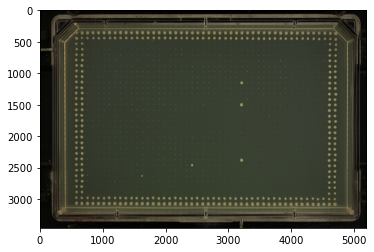

In [51]:
p = './images/MTX_selection2_20221011/'
outp = p[:-1]+'_edit/'
pic_fname = 'd000263_300_069_22-10-09_13-35-49.JPG'

#Visualization of original picture
image = io.imread(p+pic_fname)
imgplot = plt.imshow(image)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

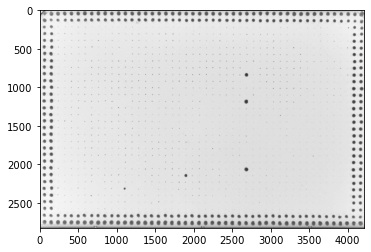

In [52]:
image = io.imread(p+pic_fname)

#Visualization of modified picture
modif = get_modified_image(image, outp, pic_fname)

#By using the function below, one can retrieve either the object, or re-load the picture from the file
imgplot = plt.imshow(modif[0], cmap='binary_r')
#image = io.imread(modif[1])
#imgplot = plt.imshow(image, cmap='binary_r')

plt.show

## Batch conversion of all pictures

In [53]:
for f in tqdm(os.listdir(p)):
    if f[-4:]== ".JPG":
        fname = os.path.basename(f)
        image = io.imread(p+fname)

        get_modified_image(image, outp, pic_fname = fname)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4990/4990 [45:31<00:00,  1.83it/s]


## Check that all pictures have been converted

In [54]:
#Here we simply check that the number of pictures is the same in both folders
nb_p =len([name for name in os.listdir(p) if os.path.isfile(p+name)])
nb_outp =len([name for name in os.listdir(outp) if os.path.isfile(outp+name)])
if nb_p == nb_outp:
    print(nb_p, nb_outp, "All photos have been succesfully converted!")
else:
    print(nb_p, nb_outp, "Some photos have not been succesfully converted...")

4990 4990 All photos have been succesfully converted!


In [14]:
#If the number is not the same in both folders, one can use the following command line to compare both folders:
#>diff -q /mnt/c/Users/Romain/OneDrive\ -\ Université\ Laval/5-FC/Robot/20210921 /home/rodur28/robotpics/20210921
#Result would given as follows: Only in /mnt/c/Users/Romain/OneDrive - Université Laval/5-FC/Robot/20210921: d000239_370_009_21-09-20_19-12-21.JPG

#Alternatively, one can compare the file names like this:
p_files = []
outp_files = []

for f in os.listdir(p):
    fname = os.path.basename(f)
    p_files.append(fname)

for f in os.listdir(outp):
    fname = os.path.basename(f)
    outp_files.append(fname)

#Note, the block below works only in one direction
for f in outp_files:
    if f not in p_files:
        print(f)

## Analyze spots with pyphe-quantify

In [4]:
# Pyphe should be installed in a virtual environment to prevent incompatibilities. Use pip install as described below, or conda install
# >conda create --name pyphe-venv python=3.7
# >pip install pyphe
# >chmod -R 777 /Users/danyamamotoevans/opt/anaconda3/bin/pyphe*
#
# To launch the virtual environment:
# >conda activate pyphe-venv
#
# Command line is typed from the folder *_edit
# >pyphe-quantify batch --grid auto_1536 --pattern "*.JPG" --s 0.1
# Grid should be adapted based on the experiment, 384, 1536, etc.

In [1]:
for i in range(52,79):
    command = "/Users/danyamamotoevans/opt/anaconda3/bin/pyphe-quantify batch --grid auto_1536 --pattern './images/MTX_selection2_20221011_edit/d00026*_300_%03d*.JPG' --out './images/MTX_selection2_20221011_edit/pyphe_quant' --s 0.1"%(i)
    #os.system(command)
    

## Analyze data generated by pyphe-quantify

In [6]:
outp = './images/MTX_selection2_20221011_edit/'

import glob
import math
from datetime import datetime
list_of_plate_df = []

for f in glob.glob(outp + 'pyphe_quant/*.csv'):  
    plate_df = pd.read_csv(f, header=0, index_col=0)

    #For every picture in the folder, the file name is read and parsed ('_') to retrieve the plate number and timestamp
    plate_df['plate_number']=f.split('.JPG.csv')[0].split("/")[-1]
    #print(plate_df['plate_number'])
        
    list_of_plate_df.append(plate_df)

#Above we created one dataframe per plate, which we now concatenate into a single dataframe
pic_df = pd.concat(list_of_plate_df, axis=0)

#This is useful if the plate has been expanded to feature 4 replicates per samples
#'spot_well' would designate a single spot (= one replicate)
#'RA_well' is short for 'rearray_well' and designates a sample on the original plate (before expansion)
#For example B1 if I'm not mistaken, corresponds to the third replicate on a 384-array of sample in A1 on the corresponding 96-array pre-expansion
pic_df['spot_well'] = pic_df.apply(lambda row: chr(64 + row.row) + str(row.column), axis=1)
pic_df['RA_well'] = pic_df.apply(lambda row: chr(64 + math.ceil(row.row / 2)) + str(math.ceil(row.column / 2)), axis=1)

pic_df.head()

,area,centroid,mean_intensity,perimeter,row,column,circularity,plate_number,spot_well,RA_well
1,2159,"(43.44881889763779, 582.4525243168133)",0.433300,175.781746,1,7,0.878041,d000263_300_011_22-10-07_20-52-48,A7,A4
2,2247,"(45.522474410324875, 758.2149532710281)",0.436059,176.367532,1,9,0.907770,d000263_300_011_22-10-07_20-52-48,A9,A5
3,2118,"(44.11331444759207, 2157.5391879131257)",0.453158,171.781746,1,25,0.901949,d000263_300_011_22-10-07_20-52-48,A25,A13
4,2075,"(43.406746987951806, 2509.938313253012)",0.452203,170.953319,1,29,0.892222,d000263_300_011_22-10-07_20-52-48,A29,A15
5,2133,"(44.61744022503516, 1021.6160337552743)",0.440047,170.953319,1,12,0.917161,d000263_300_011_22-10-07_20-52-48,A12,A6


In [7]:
pic_df.to_csv('MTX_selection2_20221011_pyphe_output_2022-12-09_Cterm.csv')

